In [1]:
%reload_ext autoreload
import pandas as pd
import numpy as np
import sys
from datastack.ml import bestmatch
reload(bestmatch)
from datastack.ml import bestmatch as bm
from scipy.stats import pearsonr
sys.path.append("../tests")
import test_bestmatch
reload(test_bestmatch)
import test_bestmatch as tbm
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
import networkx as nx
sns.set_context("poster")
% matplotlib inline

## Overview

This notebook compares the performance of two approaches to attribute-based matching. The first simply takes the maximum likelihood guess for each individual. The second places all the probabilities onto a graph and then optimizes all pairs at the same time.

## Read in data

In [5]:
N_train = 1000
n_var_list = [1, 5, 10, 20]
n_test_list = [10, 50, 100]
n_rep = 3

graph_accuracy = pd.DataFrame(index=n_var_list, columns=n_test_list)
naive_accuracy = graph_accuracy.copy()
for vv in n_var_list:
    for tt in n_test_list:
        n_finished = 0
        for rr in range(n_rep):
            basename = "train%s_%svars_%stest_rep%s" % (N_train, vv, tt, rr + 1)
            try:
                df = pd.read_table("../data_local/accuracy/%s.txt" % basename, 
                                   index_col=0, header=None).iloc[:, 0]
                #print df
                if n_finished == 0:
                    mean_val = df
                else:
                    mean_val += df
                
                n_finished += 1
            except Exception as e1:
                print e1
                pass
        if n_finished > 0:
            mean_val /= n_finished
            graph_accuracy.ix[vv, tt] = mean_val["graph"]
            naive_accuracy.ix[vv, tt] = mean_val["naive_overall"]
        

## Reshape data

In [13]:
kwargs = {'id_vars': "N. variables",
            'value_name': "Accuracy",
             'var_name': "Pool size"}
graph_accuracy.index.name = kwargs["id_vars"]
naive_accuracy.index.name = kwargs["id_vars"]
graph_accuracy_m = pd.melt(graph_accuracy.reset_index(), **kwargs)
graph_accuracy_m["type"] = "Graph"

naive_accuracy_m = pd.melt(naive_accuracy.reset_index(), **kwargs)
naive_accuracy_m["type"] = "Naive"
df = pd.concat([graph_accuracy_m, naive_accuracy_m], axis=0)

# Graph-based optimization improves on pair-by-pair prediction

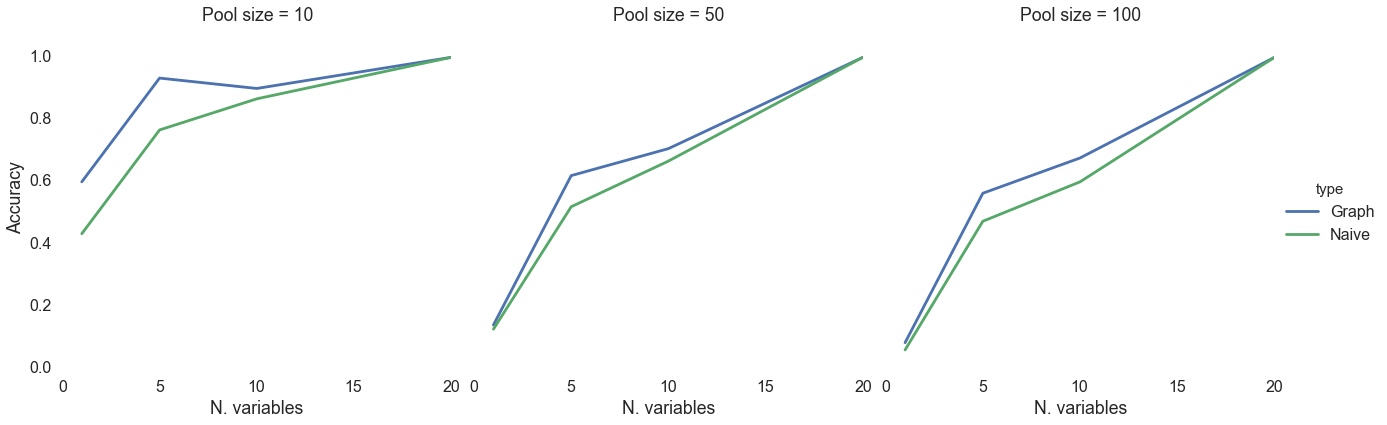

In [12]:
fac = sns.FacetGrid(data=df, hue="type", col=kwargs["var_name"], size=6)
fac.set(ylim=(0, 1.1))

fac.map(plt.plot, kwargs["id_vars"], kwargs["value_name"])
fac.add_legend()